Quantile regression and expectile regression
---------

### Introduction: quantile regression

Suppose, from some unknown distribution of $(y, X)$, we draw a random sample $\{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$, where $x_i$ is a $p$-dimensional covariates/features/predictors and $y_i$ is an interesting response. We stack these sample into: $y \in R^n$ and $X \in R^{n\times p}$. We assume the conditional quantile of $y$ given $X$ (denoted as $Q_{\tau}(y|X)$) is the following linear model:

$$Q_{\tau}(y|X)=X \beta^{*}_{\tau},$$

where $\beta^{*}_{\tau}$ is the regression coefficient vector for modeling $Q_{\tau}(y|X)$. 

Why quantile regression is helpful? Here are the advantages in Wiki [[1]](#refer-anchor-1).

- Quantile regression enables the understand of the impact of covariates on more generally the tails of the distribution of the response. This supports more comprehensively analyse for the relationship between variables. For example, a application of quantile regression is in the areas of growth charts, where percentile curves are commonly used to screen for abnormal growth.

- The quantile regression estimates are more robust against outliers in the response measurements.

But, in reality, $\beta^{*}_{\tau}$ is unknown and has to be estimated by data $\{(x_1, y_1), \ldots, (x_n, y_n)\}$. The estimation approach is minimizing the loss function:

$$\arg\min_{\beta} \sum_{i=1}^n r_{\tau}(y_i - x_i^\top\beta),$$

where $r_{\tau}(m) = m (\tau - I(m<0))$ and $I(\cdot)$ is the indicator function. 

### Sparse quantile linear model

Nowadays, the number of predictor may be hundreds or even thousands. To gain a more interpretable model, a natural idea is encouraging sparsity when minimizing the loss function [[2]](#refer-anchor-2), [[3]](#refer-anchor-3). With `skscope`, we can easily solve the following sparsity-constrain quantile regression:

$$\arg\min_{\beta} \sum_{i=1}^n r_{\tau}(y_i - x_i^\top\beta) \; \textup{s.t.} \|\beta\|_0 \leq s.$$

Here, we restrict the number of non-zero entries in $\beta$ (i.e., $\|\beta\|_0$) is smaller than $s$. 

We now use the `skscope` to solve this problem. To exemplify our implementation, we first generate synthetic datasets via the following model:

$$y_i = x_i^\top \beta^* + \epsilon$$

where $\epsilon$ comes from the standard normal distribution $N(0, 1)$, and the first element of $x_i$ is the intercept term (takes value 1) and the rest elements are $i.i.d.$ drawn from the $N(0, 1)$. We set $\beta^{*} = (9, 7, 5, 3, 0, 0, \ldots, 0)$. Under this model, we have 
$$Q_{0.975}(y_i|x_i) = x_i^\top (9+1.96, 7, 5, 3, 0, 0, \ldots, 0)$$
$$Q_{0.5}(y_i|x_i) = x_i^\top (9, 7, 5, 3, 0, 0, \ldots, 0)$$
$$Q_{0.025}(y_i|x_i) = x_i^\top (9-1.96, 7, 5, 3, 0, 0, \ldots, 0)$$

Below is the code for synthesizing data. 

In [7]:
import numpy as np

n, p = 2000, 100
np.random.seed(1)
X = np.random.normal(0, 1, (n, p))
print(X.shape)
X[:, 0] = X[:, 0] / X[:, 0]
beta = np.zeros(p)
beta[:4] = [9, 7, 5, 3]
effect_vars = np.flatnonzero(beta)
y = X @ beta + np.random.normal(0, 1, n)

(2000, 100)


Next, we use the `ScopeSolver` to estimate the underlying $\beta^*_{0.975}$. 

In [8]:
import jax.numpy as jnp
from skscope import ScopeSolver

QUANTILE = 0.975
def quanreg_loss(params):
    diff = y - X @ params
    weight = jnp.where(diff < 0, QUANTILE - 1, QUANTILE)
    loss = jnp.mean(weight * diff)
    return loss
solver = ScopeSolver(p, sparsity=4, always_select=1)
params_upper = solver.solve(quanreg_loss)
print("Selected variables: {}, \nestimated coefficients: {}".format(
    solver.get_support(), 
    params_upper[solver.get_support()]),
)

TypeError: pywrap_Universal(): incompatible function arguments. The following argument types are supported:
    1. (arg0: object, arg1: UniversalModel, arg2: Callable[[Callable[[numpy.ndarray[numpy.float64[m, 1]], object], float], Callable[[numpy.ndarray[numpy.float64[m, 1]], object], Tuple[float, numpy.ndarray[numpy.float64[m, 1]]]], numpy.ndarray[numpy.float64[m, 1]], numpy.ndarray[numpy.int32[m, 1]], object], Tuple[float, numpy.ndarray[numpy.float64[m, 1]]]], arg3: int, arg4: int, arg5: int, arg6: int, arg7: int, arg8: int, arg9: bool, arg10: int, arg11: float, arg12: int, arg13: numpy.ndarray[numpy.int32[m, 1]], arg14: numpy.ndarray[numpy.float64[m, 1]], arg15: int, arg16: int, arg17: int, arg18: numpy.ndarray[numpy.int32[m, 1]], arg19: numpy.ndarray[numpy.int32[m, 1]], arg20: int, arg21: int, arg22: int, arg23: numpy.ndarray[numpy.int32[m, 1]], arg24: numpy.ndarray[numpy.int32[m, 1]], arg25: numpy.ndarray[numpy.float64[m, 1]], arg26: numpy.ndarray[numpy.float64[m, 1]]) -> Tuple[numpy.ndarray[numpy.float64[m, 1]], float, float, float]

Invoked with: (), <scope._scope.UniversalModel object at 0x16845e4b0>, <function convex_solver_nlopt at 0x167b7ca60>, 100, 1, 0, 20, 5, 1, True, False, True, True, 1, 1.0, 1, array([4], dtype=int32), array([0.]), 0, 0, -1, array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int32), array([1], dtype=int32), 1, 0, 128, array([], dtype=int32), array([], dtype=int32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([], dtype=float64)

We can see that the solver correctly select the effective variables. The estimated non-zero coefficients is very closed to the ground truth $(10.96, 7, 5, 3)^\top$. 

Next, we plot the estimated quantile regression model. 

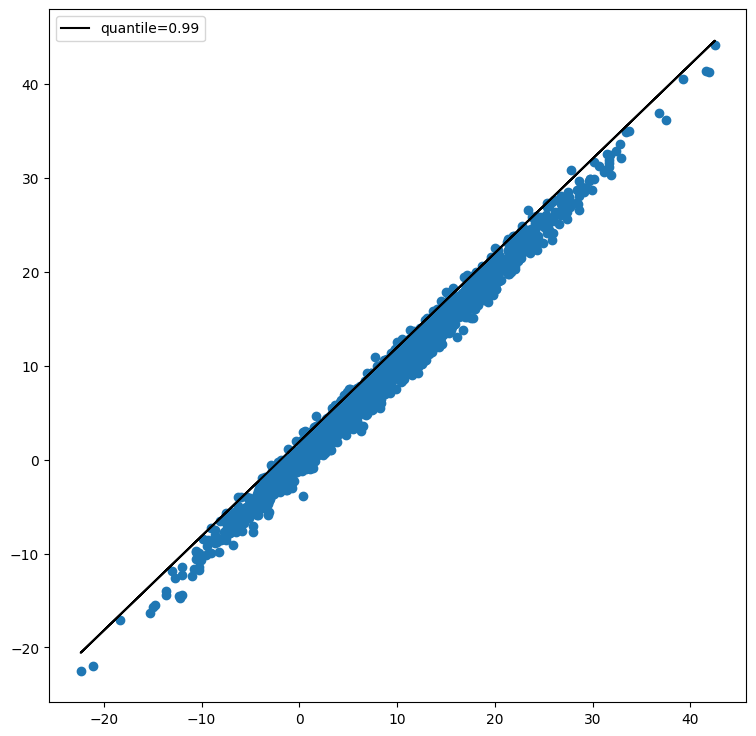

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
b_upper, a_upper = np.polyfit(X @ beta, X @ params_upper, deg=1)
ax.scatter(X @ beta, y)
ax.plot(X @ beta, a_upper + b_upper * (X @ beta), color="k", lw=1.5, label='quantile=0.99')
ax.legend()

From the above figure, we see that estimated model upperly bound the observations.

Similarly, we can estimate the models when $\tau = 0.5$ and $\tau = 0.025$. The implementation based on the `scope` is given below. 

In [ ]:
QUANTILE = 0.5
solver = ScopeSolver(p, sparsity=4, always_select=1)
params_ols = solver.solve(quanreg_loss)
print("Selected variables: {}, \nestimated coefficients: {}".format(
    solver.get_support(), 
    params_ols[solver.get_support()]),
)
QUANTILE = 0.025
solver = ScopeSolver(p, sparsity=4, always_select=1)
params_lower = solver.solve(quanreg_loss)
print("Selected variables: {}, \nestimated coefficients: {}".format(
    solver.get_support(), 
    params_lower[solver.get_support()]),
)

Selected variables: [0 1 2 3], 
estimated coefficients: [8.97916353 6.99756945 4.99368271 2.98584495]
Selected variables: [0 1 2 3], 
estimated coefficients: [6.94788394 7.07152796 5.02274821 3.01699366]


Again, the effective variables are perfectly selected; additionally, the estimated coefficient vectors are closed to the $(9, 7, 5, 3)^\top$ and $(7.04, 7, 5, 3)$, respectively. Then, we visualize the above three models: 

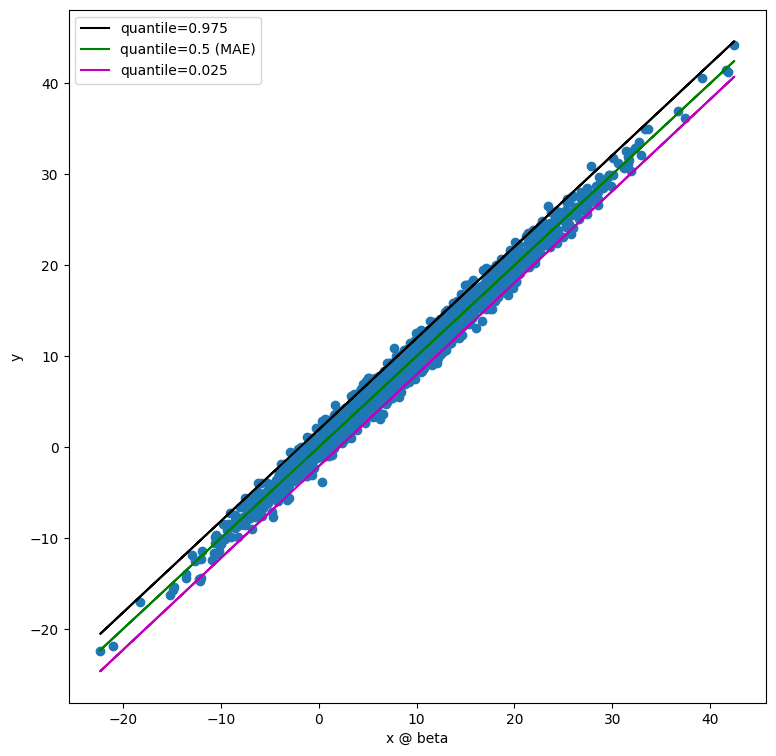

In [ ]:
b_upper, a_upper = np.polyfit(X @ beta, X @ params_upper, deg=1)
b_ols, a_ols = np.polyfit(X @ beta, X @ params_ols, deg=1)
b_lower, a_lower = np.polyfit(X @ beta, X @ params_lower, deg=1)
fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(X @ beta, y)
ax.plot(X @ beta, a_upper + b_upper * (X @ beta), color="k", lw=1.5, label='quantile=0.975')
ax.plot(X @ beta, a_ols + b_ols * (X @ beta), color="g", lw=1.5, label='quantile=0.5 (MAE)')
ax.plot(X @ beta, a_lower + b_lower * (X @ beta), color="m", lw=1.5, label='quantile=0.025')
ax.set_ylabel("y")
ax.set_xlabel("x @ beta")
ax.legend()

We can see that the three models properly capture $Q_{\tau}(y|x)$. 

### Sparse expectile regression

Expectile regression is an alternative possibility for characterizing the conditional distribution. It is first proposed in 1970s, and nowadays, it gains increasing interest such as reinforcement learning [[4]](#refer-anchor-4). For expectile regression, the loss function is replaced with:

$$\arg\min_{\beta} \sum_{i=1}^n (r_{\tau}(y_i - x_i^\top\beta))^2,$$ 

which is very similar to that in quantile regression. Notably, expectiles regression contain the ordinary linear regression as a special case (with $\tau=0.5$). To see this, we visualize the curve of function: $(r_{\tau}(u))^2$.



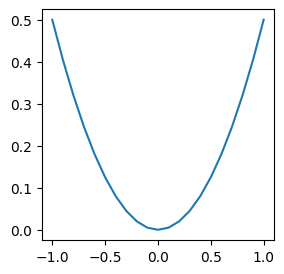

In [ ]:
def square_r_fun(u):
    tau = 0.5
    weight = np.where(u < 0, 1 - tau, tau)
    return weight * (u**2)
x = np.arange(-1.0, 1.01, step=0.1)
fig, ax = plt.subplots(figsize = (3, 3))
ax.plot(x, square_r_fun(x))

Similarly, we can conduct variable selection for expectile regression, which is formulated as a sparsity-constrained optimization:

$$\arg\min_{\beta} \sum_{i=1}^n (r_{\tau}(y_i - x_i^\top\beta))^2 \; \textup{s.t.} \|\beta\|_0 \leq s,$$

where the objective function is implemented as:

In [ ]:
EXPECTILE = np.nan
def asym_loss(params):
    diff = y - X @ params
    weight = jnp.where(diff < 0, 1 - EXPECTILE, EXPECTILE)
    loss = jnp.mean(weight * (diff**2))
    return loss

We optimize the objective with the previous synthetic dataset at expectile 0.025, 0.5 and 0.975. 

In [ ]:
EXPECTILE = 0.975
solver = ScopeSolver(p, sparsity=4, always_select=1)
params_upper = solver.solve(asym_loss)
print("Selected variables: {}, \nestimated coefficients: {}".format(
    solver.get_support(), 
    params_upper[solver.get_support()]),
)
EXPECTILE = 0.5
solver = ScopeSolver(p, sparsity=4, always_select=1)
params_ols = solver.solve(asym_loss)
print("Selected variables: {}, \nestimated coefficients: {}".format(
    solver.get_support(), 
    params_ols[solver.get_support()]),
)
EXPECTILE = 0.025
solver = ScopeSolver(p, sparsity=4, always_select=1)
params_lower = solver.solve(asym_loss)
print("Selected variables: {}, \nestimated coefficients: {}".format(
    solver.get_support(), 
    params_lower[solver.get_support()]),
)

Selected variables: [0 1 2 3], 
estimated coefficients: [10.40983627  7.01664256  5.02507904  3.0124289 ]
Selected variables: [0 1 2 3], 
estimated coefficients: [8.99668813 6.99586902 5.0008044  2.98165417]
Selected variables: [0 1 2 3], 
estimated coefficients: [7.54970328 7.02671685 5.03644048 2.95786884]


Again, we see that the effective variables are correctly selected. And we visualize the three estimated models below. 

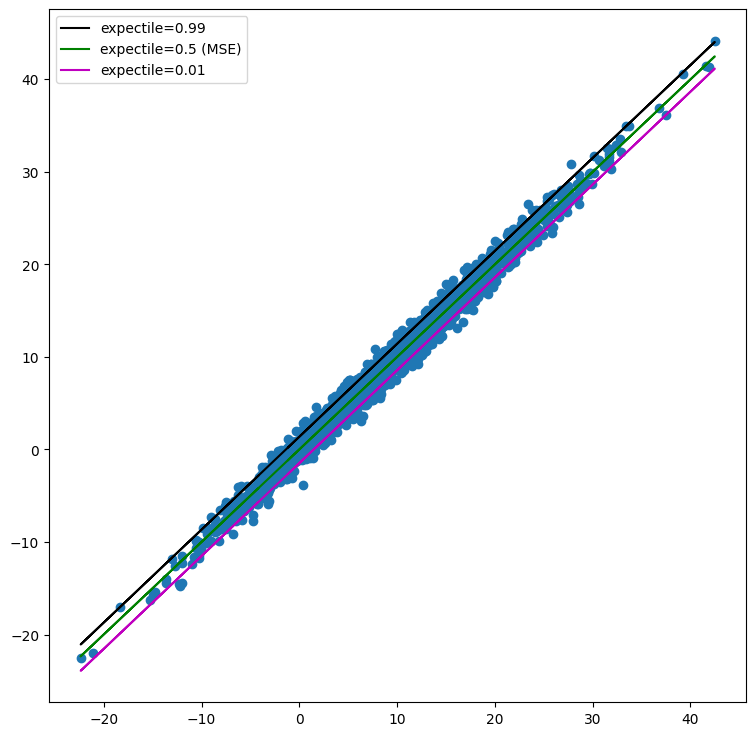

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6, 6))
b_upper, a_upper = np.polyfit(X @ beta, X @ params_upper, deg=1)
b_ols, a_ols = np.polyfit(X @ beta, X @ params_ols, deg=1)
b_lower, a_lower = np.polyfit(X @ beta, X @ params_lower, deg=1)
ax.scatter(X @ beta, y)
ax.plot(X @ beta, a_upper + b_upper * (X @ beta), color="k", lw=1.5, label='expectile=0.99')
ax.plot(X @ beta, a_ols + b_ols * (X @ beta), color="g", lw=1.5, label='expectile=0.5 (MSE)')
ax.plot(X @ beta, a_lower + b_lower * (X @ beta), color="m", lw=1.5, label='expectile=0.01')
ax.legend()

We can notice that the three models also provide a reasonable estimation for conditional expectile and conditional mean. 

#### Comparison between expectile regression and quantile regression

- Quantile regression is more resistant to outliers than expectile regression because quantile regression use $\ell_1$ norm that is more robust against outliers. 

- In the field of risk measures for financial assets, the use of expectiles as a risk measure as they have
desirable properties. 

### Reference

<div id="refer-anchor-1"></div>

- [1] Quantile regression. https://en.wikipedia.org/wiki/Quantile_regression

<div id="refer-anchor-2"></div>

- [2] Alexandre Belloni. Victor Chernozhukov. "$\ell_1$-penalized quantile regression in high-dimensional sparse models." Ann. Statist. 39 (1) 82 - 130, February 2011. https://doi.org/10.1214/10-AOS827

<div id="refer-anchor-3"></div>

- [3] Wu, Yichao, and Yufeng Liu. "Variable selection in quantile regression." Statistica Sinica (2009): 801-817.

<div id="refer-anchor-4"></div>

- [4] Ilya Kostrikov and Ashvin Nair and Sergey Levine. Offline Reinforcement Learning with Implicit Q-Learning. International Conference on Learning Representations (2022)
